## Augmentation, Morphology and Restoration

In [25]:
import numpy as np
from skimage.io import imread
from skimage.transform import rotate
from skimage.transform import warp, AffineTransform
import matplotlib.pyplot as plt 
%matplotlib inline

In [26]:
image = imread('image.jpg')
img_array = np.array(image)
print(img_array.shape)

(913, 688, 3)


In [27]:
# Rotation
def rotate_image(cx, cy, theta):

    theta = np.deg2rad(theta)
    
    trans_mat = np.array([
        [1, 0, -cx],
        [0, 1, -cy],
        [0, 0, 1]
    ])
                          
    trans_back = np.array([
        [1, 0, cx],
        [0, 1, cy],
        [0, 0, 1]
    ])
    
    rot_mat = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
        ])
    
    M = trans_back@rot_mat@trans_mat
                        
    return M

# Reflection

def reflect_image(cx, cy, axis):

    trans_mat = np.array([
        [1, 0, -cx],
        [0, 1, -cy],
        [0, 0, 1]
    ])

    trans_back = np.array([
        [1, 0, cx],
        [0, 1, cy],
        [0, 0, 1]
    ])

    if axis == 'x':
        reflect_mat = np.array([
            [1, 0, 0],
            [0, -1, 0],
            [0, 0, 1]
        ])
    elif axis == 'y':
        reflect_mat = np.array([
            [-1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError("Axis must be 'x' or 'y'")
    
    M = trans_back@reflect_mat@trans_mat

    return M

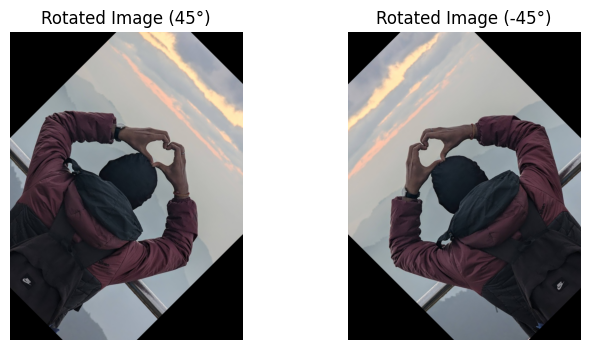

In [28]:
# Get center of image
cy, cx = image.shape[0] / 2, image.shape[1] / 2

# Get transformation matrix
M = rotate_image(cx, cy, theta=45)
N = rotate_image(cx, cy, theta=-45)

# Wrap matrix into AffineTransform
tf = AffineTransform(matrix=M)
tf1 = AffineTransform(matrix=N)
# Apply warp
rotated = warp(image, inverse_map=tf.inverse)
rotated1 = warp(image, inverse_map=tf1.inverse)
# Show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(rotated)
plt.title("Rotated Image (45°)")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(rotated1)
plt.title("Rotated Image (-45°)")
plt.axis('off')
plt.show()

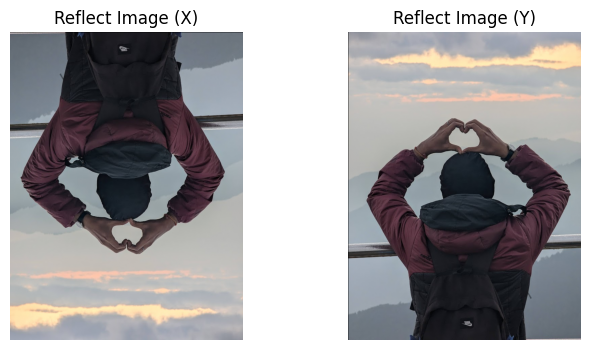

In [34]:
# Get center of image
cy, cx = image.shape[0] / 2, image.shape[1] / 2

# Get transformation matrix
M = reflect_image(cx, cy, axis = 'x')
N = reflect_image(cx, cy, axis = 'y')

# Wrap matrix into AffineTransform
tf = AffineTransform(matrix=M)
tf1 = AffineTransform(matrix=N)
# Apply warp
reflected = warp(image, inverse_map=tf.inverse)
reflected1 = warp(image, inverse_map=tf1.inverse)
# Show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(reflected)
plt.title("Reflect Image (X)")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reflected1)
plt.title("Reflect Image (Y)")
plt.axis('off')
plt.show()